---
### Closed-Form Solution with Mass-Action Kinetics

Solve for growth rate and Y with built-in Python optimization library

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
r1 = 210
r2 = 1400
N = 200
b_min = 1e-4
b_max = 0.1
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

## Functions

In [14]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2 = u
    logZ = logsumexp([u1, 0.0, u2])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(-logZ)
    theta3 = np.exp(u2 - logZ)
    return theta1, theta2, theta3

# Objective function for fixed b_val using softmax
def objective_softmax(u, b_val):
    try:
        theta1, theta2, theta3 = softmax_partition(u)
        if theta1 <= 0 or theta3 <= 0:
            return np.inf
        
        term1 = (r1 * theta2) / (b_val * theta1)
        term2 = (r2 * theta3) / (b_val * theta1)
        Y1 = 1 / (1 + term1)
        Y2 = term1 / (1 + term2) * Y1
        Y3 = (r2 * theta3 / b_val) * Y2
        return -b_val * Y3  # Negative lambda (maximize lambda)
    except:
        return np.inf

def optimize_for_b_softmax(b_val, tol=1e-7, gtol=1e-8, maxiter=1000):
    result = minimize(
        lambda u: objective_softmax(u, b_val),
        x0=[0.0, 0.0],
        method='BFGS',
        tol=tol,                       # global tolerance
        options={
            'gtol': gtol,              # gradient tolerance
            'maxiter': maxiter,        # maximum iterations
            'disp': True               # display output: True
        }
    )
    if result.success:
        theta1, theta2, theta3 = softmax_partition(result.x)
        term1 = (r1 * theta2) / (b_val * theta1)
        term2 = (r2 * theta3) / (b_val * theta1)
        Y1 = 1 / (1 + term1)
        Y2 = term1 / (1 + term2) * Y1
        Y3 = (r2 * theta3 / b_val) * Y2
        Y4 = (r2 * theta2 * theta3) / (b_val * theta1) * Y2
        Y5 = (r2 * theta3**2) / (b_val * theta1) * Y2
        lambda_val = b_val * Y3
        r_denom = (1/(r1 * Y4)) + (1/(r2 * Y5))
        r_avg = 1 / r_denom if r_denom != 0 else np.nan
        return np.array([b_val, theta1, theta2, theta3, Y1, Y2, Y3, Y4, Y5, lambda_val, r_avg])
    return None

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = [r for r in results if r is not None]
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

# Convert results to a 2D numpy array
results_array = np.array(results)

# Extract individual arrays (each column corresponds to a variable)
b_arr = results_array[:, 0]
theta1_arr = results_array[:, 1]
theta2_arr = results_array[:, 2]
theta3_arr = results_array[:, 3]
Y1_arr = results_array[:, 4]
Y2_arr = results_array[:, 5]
Y3_arr = results_array[:, 6]
Y4_arr = results_array[:, 7]
Y5_arr = results_array[:, 8]
lambda_arr = results_array[:, 9]
r_avg_arr = results_array[:, 10]

Optimization completed in 0.58 seconds.


## Plots

Sum of biomass fractions (should be 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Sum of theta fractions (should be 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

<>:121: SyntaxWarning: invalid escape sequence '\l'
<>:121: SyntaxWarning: invalid escape sequence '\l'
C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:121: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel(r'$\lambda$')
C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


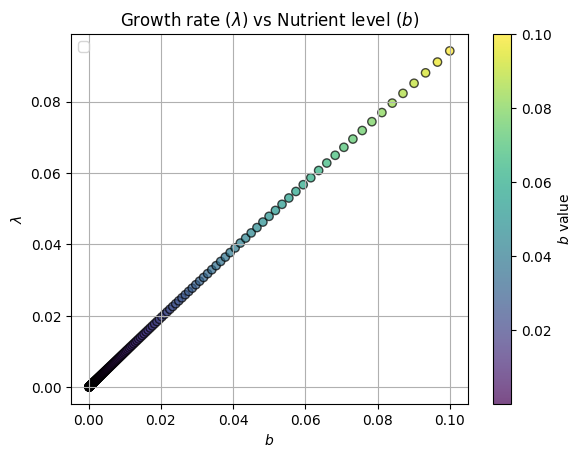

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


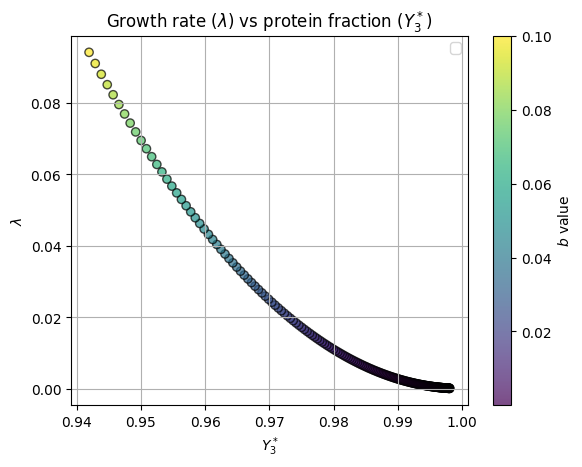

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


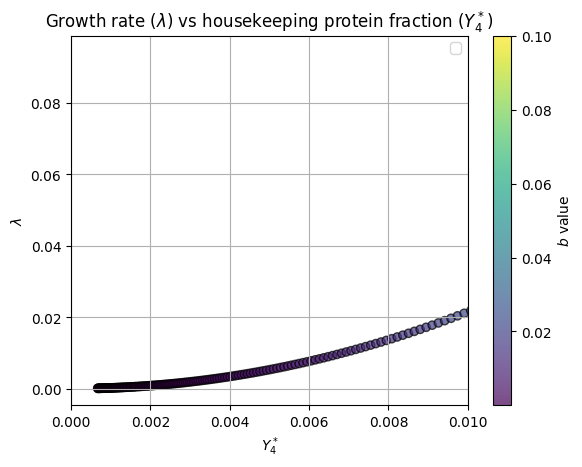

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


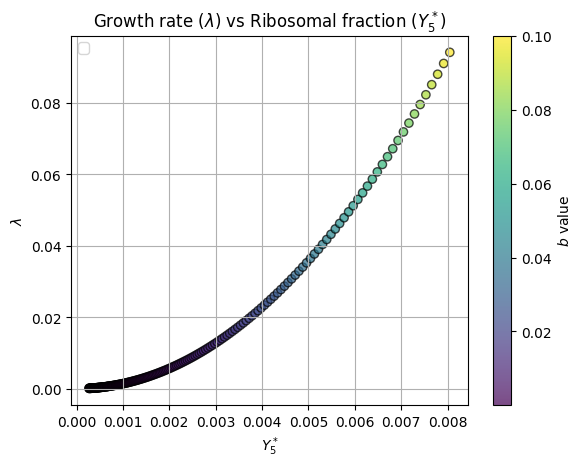

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


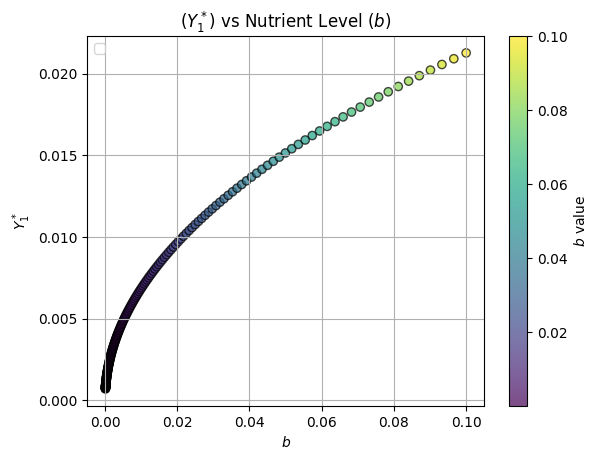

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


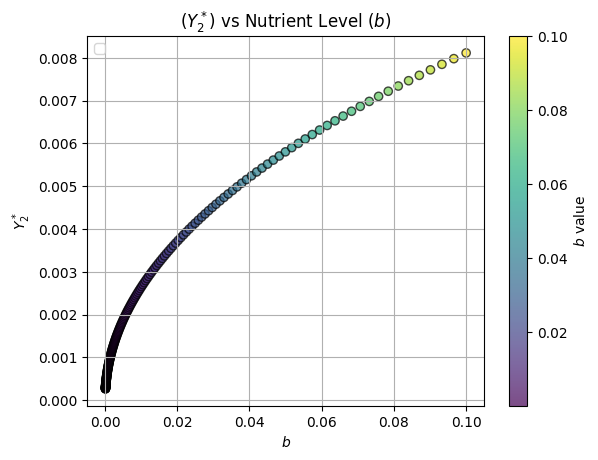

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


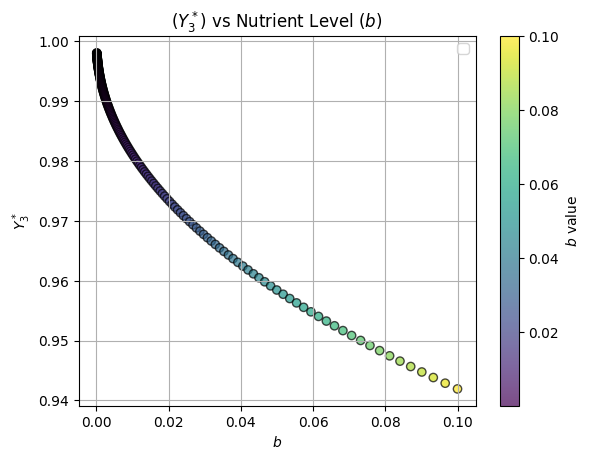

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


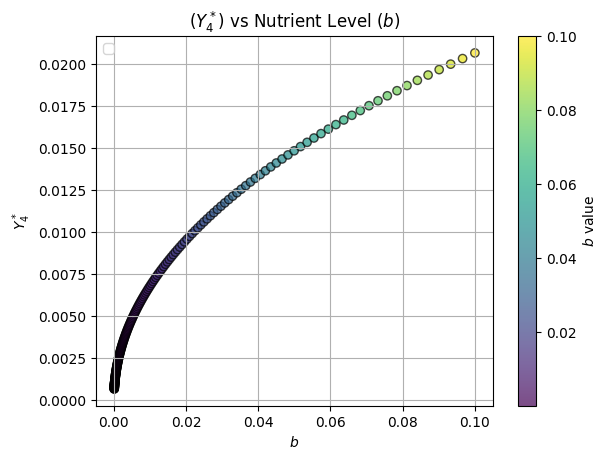

C:\Users\huang\AppData\Local\Temp\ipykernel_26852\510482091.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


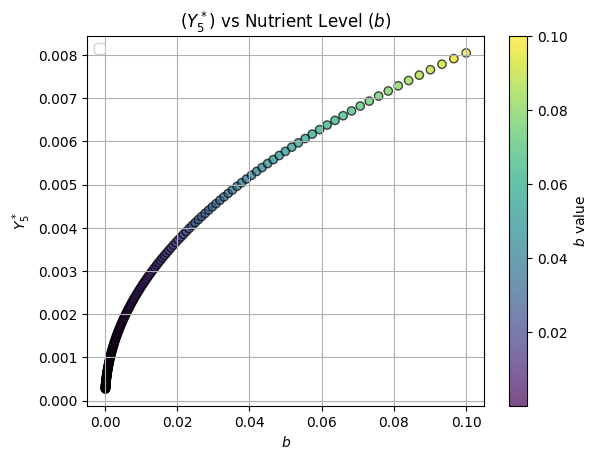

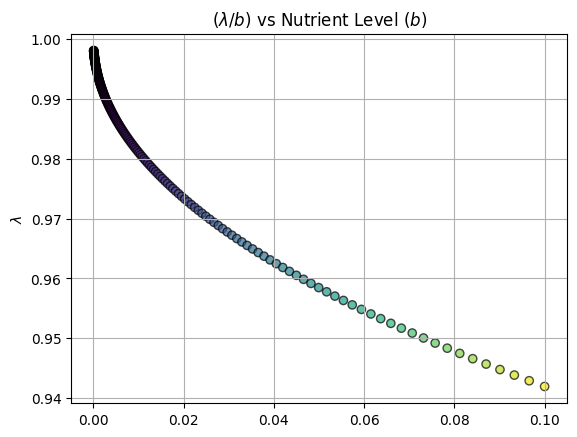

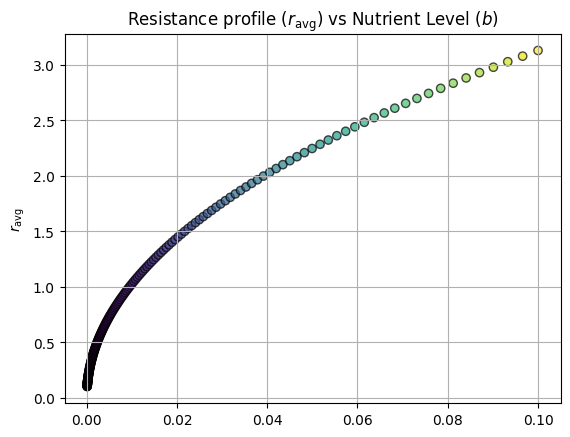

"# Growth rate to (truncated) ribosomal fraction (Y5)\nplt.figure()\nplt.plot(Y5_trunc, lambda_trunc, lw=2, label=r'', marker='o', color='blue')\nplt.plot(Y5_lambda_trunc_fit[0], Y5_lambda_trunc_fit[1], '-', label=f'Linear fit: y = {Y5_lambda_trunc_fit[3]:.3f}x + {Y5_lambda_trunc_fit[4]:.3f}\n$R^2$ = {Y5_lambda_trunc_fit[2]:.4f}', color='red') # line of best fit\nplt.xlabel(r'$Y_5^*$')\nplt.ylabel(r'$\\lambda$')\nplt.title(r'Growth rate ($\\lambda$) vs (Truncated) Ribosomal fraction ($Y_5^* > 0.10$)')\nplt.grid(True)\nplt.legend()\nplt.show()"

In [ ]:
# Growth rate to nutrient level (b)
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_3^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y4_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_4^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_4^*$)')
plt.grid(True)
plt.xlim(0, 0.01)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5)
plt.figure()
scatter = plt.scatter(Y5_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_5^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_5^*$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y1) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y1_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_1^*$')
plt.title(r'($Y_1^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y2) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y2_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_2^*$')
plt.title(r'($Y_2^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y3) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y3_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_3^*$')
plt.title(r'($Y_3^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y4) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y4_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_4^*$')
plt.title(r'($Y_4^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y5) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_5^*$')
plt.title(r'($Y_5^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()


# Yield per unit input
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr / b_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.ylabel(r'$\lambda$')
plt.title(r'($\lambda / b$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

# Efficiency and Tradeoffs
plt.figure()
scatter = plt.scatter(b_arr, r_avg_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.ylabel(r'$r_\text{avg}$')
plt.title(r'Resistance profile ($r_\text{avg}$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

'''# Growth rate to (truncated) ribosomal fraction (Y5)
plt.figure()
plt.plot(Y5_trunc, lambda_trunc, lw=2, label=r'', marker='o', color='blue')
plt.plot(Y5_lambda_trunc_fit[0], Y5_lambda_trunc_fit[1], '-', label=f'Linear fit: y = {Y5_lambda_trunc_fit[3]:.3f}x + {Y5_lambda_trunc_fit[4]:.3f}\n$R^2$ = {Y5_lambda_trunc_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_5^*$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs (Truncated) Ribosomal fraction ($Y_5^* > 0.10$)')
plt.grid(True)
plt.legend()
plt.show()'''